In [70]:
from ROOT import (
    PlotUtils,
    TH1,
    TFile,
    TCanvas,
    TGraph,
    TGraphErrors,
    TF1,
    kFALSE,
    TMath,
    gPad,
    gStyle,
    TLatex,
    kRed,
)
import os
import sys
import array as ar

In [2]:
if "canvas" in locals():
    del canvas
canvas = TCanvas("canvas", "canvas", 800, 600)

### Load file, input hist

In [3]:
TH1.AddDirectory(kFALSE)

mcfile = TFile.Open("scaled_MC.root")

FIT_FORM = "[0]*x + [1]*sqrt(x)"

# func2 = TF1('func2', 'gaus',350., 3000.)
# func3 = TF1('func3', '[0]*x + [1]*sqrt(x)+gaus(3)', 0.0, 3000.)
# func = TF1('func', 'landau', 0.0, 3000.)

# Get input 2D hist

# N.B. the x-axis LABEL of this plot is WRONG: it's tpi not range
range_tpi_hist = mcfile.Get("Pion_Range_vs_Pion_KE_signal")
range_tpi_hist.SetDirectory(0)

# re-use the hist name
range_tpi_hist = range_tpi_hist.GetCVHistoWithStatError()
range_tpi_hist.GetYaxis().SetTitle("Pion Range (mm)")
range_tpi_hist.GetXaxis().SetTitle("Pion KE (MeV)")
n_tpi_bins = range_tpi_hist.GetNbinsX() + 1
n_range_bins = range_tpi_hist.GetNbinsY() + 1
print(
    "There are ", n_tpi_bins, " NXBins (PionKE) and ", n_range_bins, " NYBins (Range)"
)

There are  34  NXBins (PionKE) and  35  NYBins (Range)


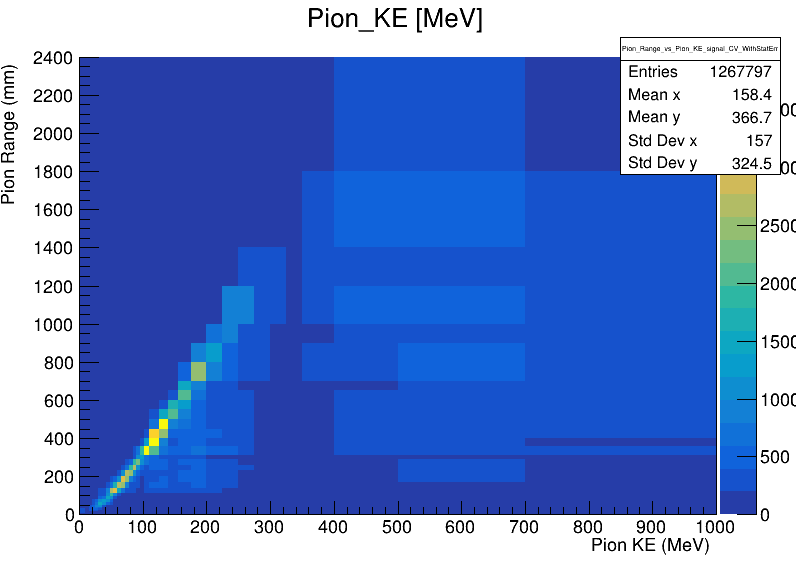

In [4]:
canvas.Clear()
range_tpi_hist.Draw("COLZ")
canvas.Update()
canvas.Draw()

### Calculate the median tpi in each bin of range

In [5]:
# ==============================================================================
# (2) Print the median Tpi for each bin of range getting bin contents manually
# and using TMath. The median rounds to a single bin center value.
# Median method: https://root.cern.ch/root/html524/TMath.html#TMath:Median
# Save to file.
# ===============================================================================
range_bin_centers = ar.array("d", [0] * n_range_bins)
tpi_medians = ar.array("d", [0] * n_range_bins)
tpierrs = ar.array("d", [0] * n_range_bins)
rangeerrs = ar.array("d", [0] * n_range_bins)

for range_bin in range(1, n_range_bins):
    range_bin_center = range_tpi_hist.GetYaxis().GetBinCenter(range_bin)

    tpi_bin_centers = ar.array("d", [0] * n_tpi_bins)
    z = ar.array("d", [0] * n_tpi_bins)
    # get array of 2D hist contents
    for tpi_bin in range(1, n_tpi_bins):
        tpi_bin_centers[tpi_bin] = range_tpi_hist.GetXaxis().GetBinCenter(tpi_bin)
        z[tpi_bin] = range_tpi_hist.GetBinContent(tpi_bin, range_bin)
    sumz = sum(z)
    median_tpi = TMath.Median(n_tpi_bins, tpi_bin_centers, z)
    meanz = TMath.RMS(n_tpi_bins, tpi_bin_centers, z)
    tpierrs[range_bin] = meanz / TMath.Sqrt(sumz) if sumz > 0 else 999

    range_bin_centers[range_bin] = range_bin_center
    tpi_medians[range_bin] = median_tpi
print(len(tpi_medians), len(range_bin_centers))

35 35


In [6]:
for range_bin in range(1, n_range_bins):
    range_bin_center = range_bin_centers[range_bin]
    median_tpi = tpi_medians[range_bin]
    tpierr = tpierrs[range_bin]
    print(f"range {range_bin_center}, median tpi {median_tpi}, tpierrs {round(tpierr,5)}")

range 0.05, median tpi 33.0, tpierrs nan
range 0.55, median tpi 17.5, tpierrs 18.63362
range 4.5, median tpi 17.5, tpierrs 3.20178
range 12.0, median tpi 22.5, tpierrs 1.98296
range 20.0, median tpi 22.5, tpierrs 1.75403
range 28.0, median tpi 27.5, tpierrs 1.40246
range 36.0, median tpi 27.5, tpierrs 1.33769
range 45.0, median tpi 33.0, tpierrs 1.33308
range 57.5, median tpi 39.0, tpierrs 1.16372
range 72.5, median tpi 45.0, tpierrs 1.20405
range 87.5, median tpi 51.0, tpierrs 1.27112
range 102.5, median tpi 51.0, tpierrs 1.28174
range 125.0, median tpi 57.0, tpierrs 0.96977
range 155.0, median tpi 69.0, tpierrs 0.99739
range 185.0, median tpi 75.0, tpierrs 1.0634
range 215.0, median tpi 81.0, tpierrs 1.12735
range 245.0, median tpi 87.0, tpierrs 1.18854
range 275.0, median tpi 93.0, tpierrs 1.27772
range 300.0, median tpi 99.0, tpierrs 1.72859
range 335.0, median tpi 106.0, tpierrs 1.16701
range 380.0, median tpi 117.5, tpierrs 1.50006
range 425.0, median tpi 132.5, tpierrs 1.53823
r

In [7]:
# Trim off outlying first bins
trimmed_range_bin_centers = range_bin_centers[2:-1]
trimmed_tpi_medians = tpi_medians[2:-1]
trimmed_rangeerrs = rangeerrs[2:-1]
trimmed_tpierrs = tpierrs[2:-1]
assert len(trimmed_range_bin_centers) == len(trimmed_tpi_medians) == len(trimmed_rangeerrs) == len(trimmed_tpierrs)

In [8]:
for range_bin in range(1, len(trimmed_range_bin_centers)):
    range_bin_center = trimmed_range_bin_centers[range_bin]
    median_tpi = trimmed_tpi_medians[range_bin]
    tpierr = trimmed_tpierrs[range_bin]
    print(f"range {range_bin_center}, median tpi {median_tpi}, tpierrs {round(tpierr,5)}")

range 4.5, median tpi 17.5, tpierrs 3.20178
range 12.0, median tpi 22.5, tpierrs 1.98296
range 20.0, median tpi 22.5, tpierrs 1.75403
range 28.0, median tpi 27.5, tpierrs 1.40246
range 36.0, median tpi 27.5, tpierrs 1.33769
range 45.0, median tpi 33.0, tpierrs 1.33308
range 57.5, median tpi 39.0, tpierrs 1.16372
range 72.5, median tpi 45.0, tpierrs 1.20405
range 87.5, median tpi 51.0, tpierrs 1.27112
range 102.5, median tpi 51.0, tpierrs 1.28174
range 125.0, median tpi 57.0, tpierrs 0.96977
range 155.0, median tpi 69.0, tpierrs 0.99739
range 185.0, median tpi 75.0, tpierrs 1.0634
range 215.0, median tpi 81.0, tpierrs 1.12735
range 245.0, median tpi 87.0, tpierrs 1.18854
range 275.0, median tpi 93.0, tpierrs 1.27772
range 300.0, median tpi 99.0, tpierrs 1.72859
range 335.0, median tpi 106.0, tpierrs 1.16701
range 380.0, median tpi 117.5, tpierrs 1.50006
range 425.0, median tpi 132.5, tpierrs 1.53823
range 475.0, median tpi 132.5, tpierrs 1.71541
range 525.0, median tpi 147.5, tpierrs 1.

### Do the fit

In [9]:
g = TGraphErrors(
    len(trimmed_range_bin_centers), trimmed_range_bin_centers, trimmed_tpi_medians, trimmed_rangeerrs, trimmed_tpierrs
)
func = TF1("func", FIT_FORM, 0.0, 350.0)
gfit = g.Clone()
gfit.SetName("TpiEst_Errs_Fit")
fit = gfit.Fit("func", "S")

chiperndf = fit.Chi2() / fit.Ndf()

 FCN=222.417 FROM MIGRAD    STATUS=CONVERGED      40 CALLS          41 TOTAL
                     EDM=9.94225e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.23466e-01   2.32227e-03   6.01414e-06   4.72581e-08
   2  p1           3.75890e+00   4.98458e-02   1.29089e-04  -6.60514e-10


In [10]:
print("Chi Squared: ", fit.Chi2(), " NdF: ", fit.Ndf())
print("Chi Squared Per Degree of Freedom: ", chiperndf)

Chi Squared:  222.4173292942422  NdF:  30
Chi Squared Per Degree of Freedom:  7.41391097647474


### Plot

In [11]:
#m = PlotUtils.MnvPlotter(PlotUtils.kCCNuPionIncStyle)
#del m

In [12]:
# fill in the curve with points
rangepoints = ar.array("d", [0] * 2400)
tpipoints = ar.array("d", [0] * 2400)
for q in range(0, 2400):
    rangepoints[q] = float(q)
    tpipoints[q] = func.Eval(q)

In [131]:
#canvas.Clear()
del canvas
canvas = TCanvas("canvas", "canvas", 800, 600)

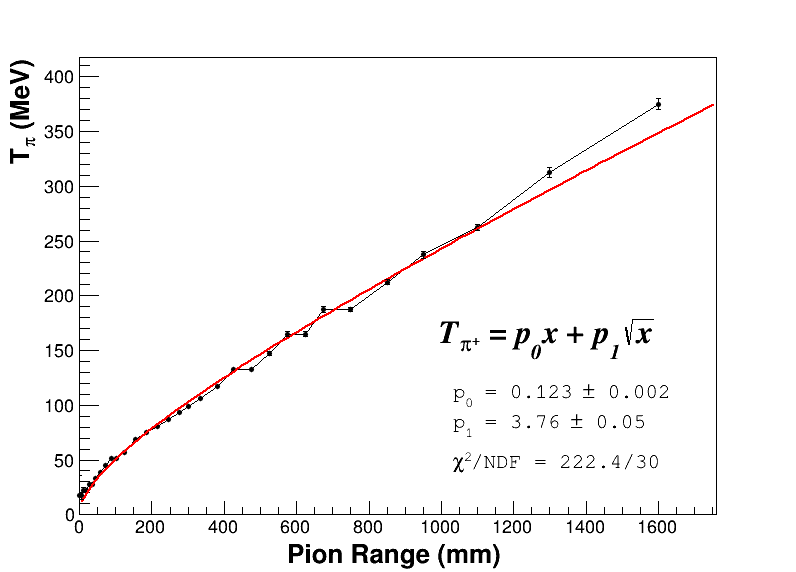

In [221]:
# draw
gfit.Draw("ALP")
gfit.SetTitle("")
gfit.SetMarkerStyle(20)
gfit.SetMarkerSize(0.5)
gfit.GetXaxis().SetLabelFont(42)  # Bold for x-axis labels
gfit.GetYaxis().SetLabelFont(42)  # Bold for y-axis labels
gfit.GetXaxis().SetTitleFont(62)
gfit.GetYaxis().SetTitleFont(62)
gfit.GetXaxis().SetTitleSize(0.05)
gfit.GetYaxis().SetTitleSize(0.05)

#gStyle.SetHistMinimumZero(True)
gStyle.SetTitleOffset( 1.15 )

gfit.SetMinimum(0)

# Adjust y-axis title offset and left margin
gfit.GetYaxis().SetTitleOffset(.9)  # Increase y-axis title distance
#gPad.SetLeftMargin(0.15)             # Increase left margin

# Adjust x-axis title offset and bottom margin
gfit.GetXaxis().SetTitleOffset(.9)
#gPad.SetBottomMargin(0.15)  

gfit.GetXaxis().CenterTitle()

#gPad.Modified()
#gPad.Update()

gfit.GetXaxis().SetTitle("Pion Range (mm)")
gfit.GetYaxis().SetTitle("T_{#pi} (MeV)")

latex1 = TLatex(0.55, 0.4, "T_{#pi^{+}} = p_{0}x + p_{1}#sqrt{x}")
latex1.SetNDC()  # Use normalized device coordinates
latex1.SetTextFont(32)  # Optional: Helvetica font
latex1.SetTextSize(0.06)  # Optional: Adjust text size
#latex1.SetTextColor(2)
latex1.Draw()

latex2 = TLatex(0.57, 0.27, "#splitline{p_{0} = 0.123 #pm 0.002}{p_{1} = 3.76 #pm 0.05}")
latex2.SetNDC()  # Use normalized device coordinates
latex2.SetTextFont(82)  # Optional: Helvetica font
latex2.SetTextSize(0.04)  # Optional: Adjust text size
#latex2.SetTextColor(2)
latex2.Draw()

latex3 = TLatex(0.57, 0.181, "#chi^{2}/NDF = 222.4/30")
latex3.SetNDC()  # Use normalized device coordinates
latex3.SetTextFont(82)  # Optional: Helvetica font
latex3.SetTextSize(0.04)  # Optional: Adjust text size
#latex3.SetTextColor(2)
latex3.Draw()



canvas.Draw()
canvas.Update()

In [223]:
canvas.SaveAs("tpi_estimator.png")
canvas.SaveAs("tpi_estimator.pdf")
canvas.SaveAs("tpi_estimator.eps")

Info in <TCanvas::Print>: png file tpi_estimator.png has been created
Info in <TCanvas::Print>: pdf file tpi_estimator.pdf has been created
Info in <TCanvas::Print>: eps file tpi_estimator.eps has been created
